In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from moviepy.editor import VideoFileClip
from ipywidgets import interact, IntSlider, FloatSlider, Layout, IntRangeSlider

In [2]:
import importlib
import mycv.camera as camera
importlib.reload(camera)
import mycv.image as image
importlib.reload(image)
import mycv.lanes as lanes
importlib.reload(lanes)
import mycv.warp as warp
importlib.reload(warp)
import mycv.pipeline as pipeline
importlib.reload(pipeline)
import mycv.filters as filters
importlib.reload(filters)
import mycv.poly as poly
importlib.reload(poly)

<module 'mycv.poly' from '/home/tom/dev/self-driving-nd/CarND-Advanced-Lane-Lines/mycv/poly.py'>

In [45]:
fits = [poly.Fit(1, 1, 1), poly.Fit(2, 2, 2)]
np.mean(np.array([poly.to_numpy(fit) for fit in fits]), axis=0)

array([1.5, 1.5, 1.5])

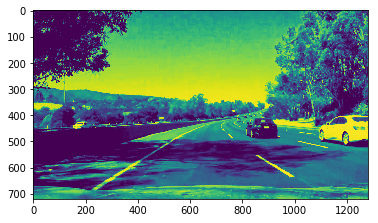

In [57]:
plt.imshow(filters.histogram_equalization(img[:, :, 0]))

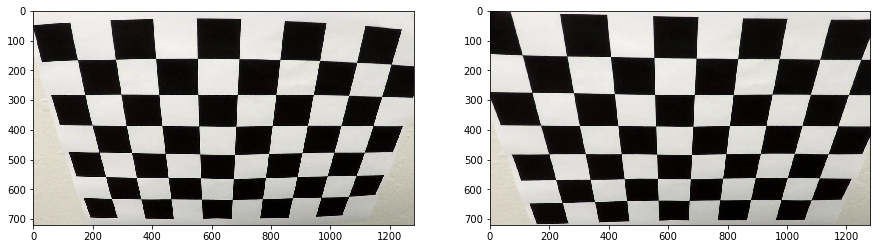

In [3]:
c = camera.Camera()
c.calibrate()
img = image.read('camera_cal/calibration2.jpg', rgb=True)
_, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].imshow(img)
axes[1].imshow(c.undistort(img))
image.write(c.undistort(img), 'output_images/undistorted_calibration.jpg')

In [117]:
clip.end

50.4

(720, 1280, 3)


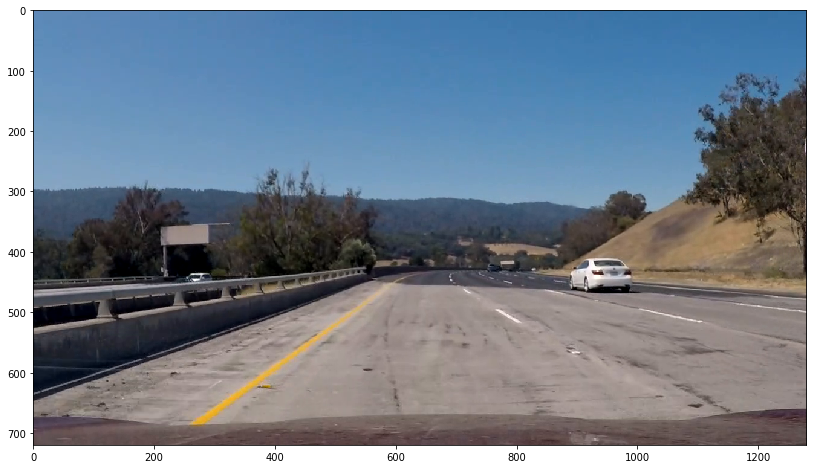

In [7]:
clip = VideoFileClip('project_video.mp4')
t_fail = 23.5
# t_fail = 24.6
# t_fail = 41.7
# t_fail = 41.54
# t_fail = 39.3
# t_fail = 27.0
# t_fail = 38.6
img = clip.get_frame(t_fail)
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
ax.imshow(img)
print(img.shape)
# image.write(img, './get_hue.jpg', rgb=True)

In [17]:
plt.figure(figsize=(15, 8))

def f(t_fail, hue, sat):
    img = clip.get_frame(t_fail/10)
    undistorted = c.undistort(img)
    
    hue_min, hue_max = hue[0:2]
    sat_min, sat_max = sat[0:2]
    
    hue_img = filters.hue(img, rgb=True)
    hue_filter = filters.threshold(hue_img, tmin=hue_min, tmax=hue_max)
    
    sat_img = filters.saturation(img, rgb=True)
    sat_filter = filters.threshold(sat_img, tmin=sat_min, tmax=sat_max)
    
    filtered = hue_filter & sat_filter
    
    warped = warp.birds_eye.transform(filtered)
    out = warped
    plt.cla()
    ax = plt.axes()
    ax.imshow(out, cmap='gray')

_ = interact(f,
             t_fail=IntSlider(value=224, min=0, max=int(clip.end*10), layout=Layout(width='100%')),
             hue=IntRangeSlider(value=[90, 110], min=0, max=255, layout=Layout(width='100%')),
             sat=IntRangeSlider(value=[0, 255], min=0, max=255, layout=Layout(width='100%')),
            )

<Figure size 1080x576 with 0 Axes>

interactive(children=(IntSlider(value=224, description='t_fail', layout=Layout(width='100%'), max=504), IntRan…

In [160]:
# undistorted = c.undistort(img)
# warped = warp.birds_eye.transform(undistorted)
# warped = warp.birds_eye.transform(img)
def f(t_fail, **kwargs):
    img = clip.get_frame(t_fail/10)
    undistorted = c.undistort(img)
    filtered = filters.main(undistorted, rgb=True, **kwargs)
    warped = warp.birds_eye.transform(filtered)
    out = warped
    plt.figure(figsize=(15, 8))
    ax = plt.axes()
    ax.imshow(out, cmap='gray')

sliders = dict([(p, pipeline.make_slider(pipeline.filter_params[p])) for p in pipeline.filter_params])
_ = interact(f, 
             t_fail=IntSlider(value=235, min=0, max=int(clip.end*10), layout=Layout(width='100%')),
             **sliders)

interactive(children=(IntSlider(value=235, description='t_fail', layout=Layout(width='100%'), max=504), IntSli…

In [107]:
# img = image.read('./test_images/test5.jpg', rgb=True)
undistorted = c.undistort(img)
# warped = warp.birds_eye.transform(undistorted)
ld = lanes.LaneDetector()
def f(sobel_mag_min, sobel_mag_max, sobel_dir_min, sobel_dir_max, saturation_min, saturation_max, hue_min, hue_max):
    filtered = filters.main(undistorted, sobel_mag_min=sobel_mag_min, sobel_mag_max=sobel_mag_max,
                           sobel_dir_min=sobel_dir_min, sobel_dir_max=sobel_dir_max,
                           saturation_min=saturation_min, saturation_max=saturation_max, 
                            hue_min=hue_min, hue_max=hue_max, rgb=True)
    warped = warp.birds_eye.transform(filtered)
#     _, _, _, _, debug_img_w = lanes.window_search(warped, debug=True)
    leftx, lefty, rightx, righty, debug_img = ld.debug(warped)
    vis_img, _, _ = lanes.visualize(img,
                           ld.left, ld.right,
                           pipeline._metres_per_pixel_x, pipeline._metres_per_pixel_y,
                          leftx, lefty, rightx, righty)
    n_ax = 3
    _, ax = plt.subplots(n_ax, 1, figsize=(15, 8*n_ax))
    ax[0].imshow(filtered, cmap='gray')
#     ax[1].imshow(debug_img_w)
    ax[1].imshow(debug_img)
    ax[2].imshow(vis_img)

_ = interact(f, 
         sobel_mag_min=IntSlider(value=30, min=0, max=255), 
         sobel_mag_max=IntSlider(value=200, min=0, max=255), 
         sobel_dir_min=FloatSlider(value=0, min=0, max=3.142/2), 
         sobel_dir_max=FloatSlider(value=0.6, min=0, max=3.142/2), 
         saturation_min=IntSlider(value=120, min=0, max=255), 
         saturation_max=IntSlider(value=255, min=0, max=255),
         hue_min=IntSlider(value=32, min=0, max=255),
         hue_max=IntSlider(value=60, min=0, max=255)
            )

interactive(children=(IntSlider(value=30, description='sobel_mag_min', max=255), IntSlider(value=200, descript…

In [140]:
p = pipeline.Pipeline()

In [141]:
# img = image.read('./test_images/test6.jpg', rgb=True)
# out = p.debug(img)
out = p.step(img, rgb=True, display=True)

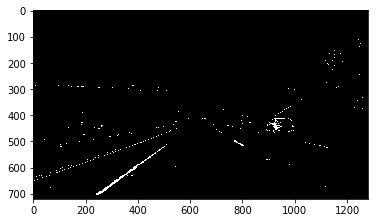

In [142]:
plt.imshow(out)

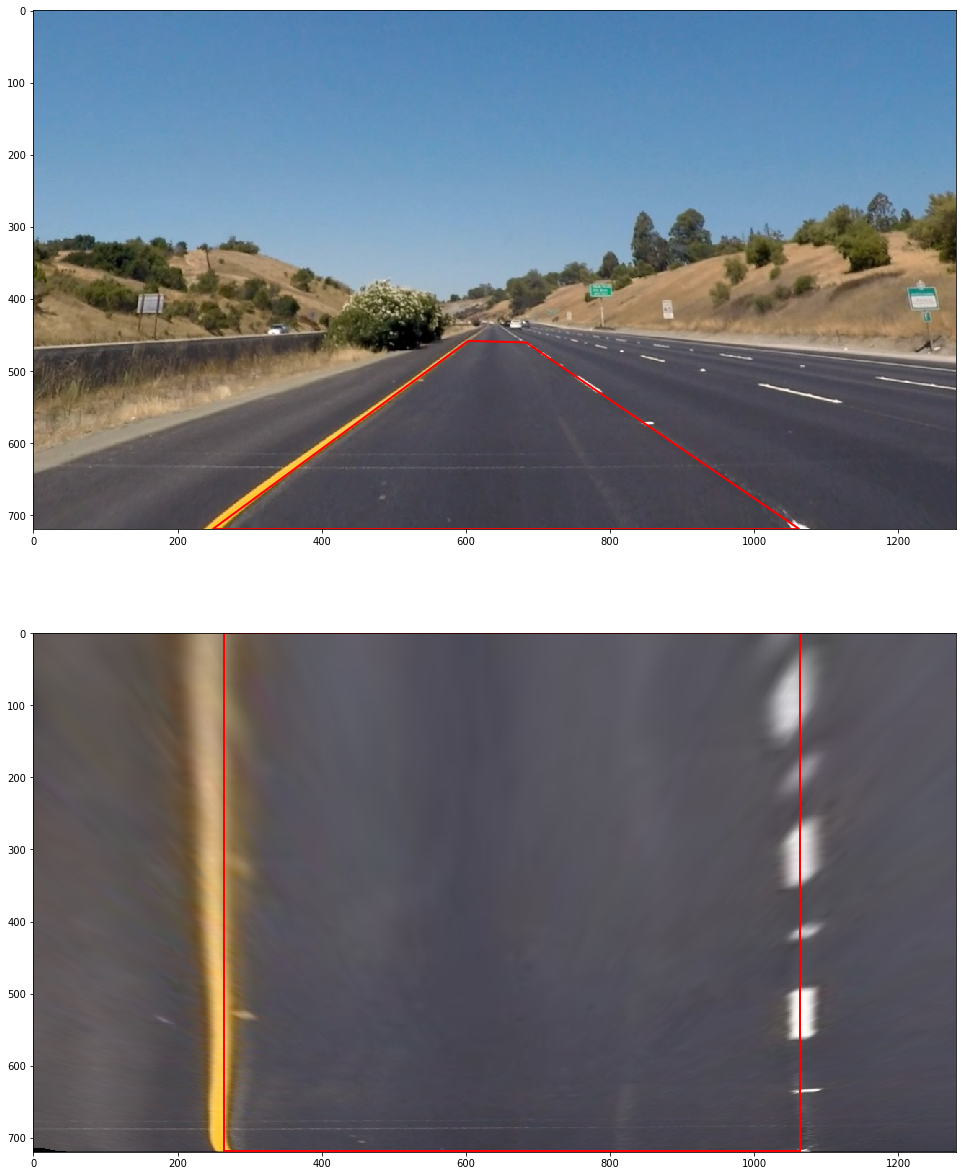

In [329]:
img = image.read('./test_images/straight_lines1.jpg', rgb=True)
c = camera.Camera()
c.calibrate()
img = c.undistort(img)
warped = warp.birds_eye.transform(img)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13*1.5, 7*1.5*2))
ax1.imshow(img)
ax1.add_patch(patches.Polygon(np.array(warp._birds_eye_image_points), fill=False, edgecolor='#ff0000', linewidth=2))
ax2.imshow(warped)
ax2.add_patch(patches.Polygon(np.array(warp._birds_eye_object_points), fill=False, edgecolor='#ff0000', linewidth=2))

In [260]:
l = lanes.LaneDetector()


In [248]:
c = camera.Camera()

720 1280
imgpoints (15, 54, 2) [[[ 437.63446  125.29032]
  [ 500.79935  124.53901]
  [ 564.22687  123.68745]
  ...
  [ 810.47296  432.32556]
  [ 869.0293   430.96164]
  [ 926.9978   430.6018 ]]

 [[ 658.3003   203.3237 ]
  [ 700.4886   200.48181]
  [ 746.4221   196.44681]
  ...
  [ 951.58203  485.74704]
  [1009.3205   491.51224]
  [1071.2775   496.41864]]

 [[ 545.3228   343.05032]
  [ 602.6792   342.8268 ]
  [ 660.09796  341.2892 ]
  ...
  [ 833.01404  556.0907 ]
  [ 878.6883   552.73303]
  [ 922.8272   549.9281 ]]

 ...

 [[  99.22318  269.60043]
  [ 119.55948  268.01456]
  [ 140.10559  266.0964 ]
  ...
  [ 233.10457  445.57333]
  [ 259.15527  447.4177 ]
  [ 285.25552  449.1626 ]]

 [[ 710.1603   216.4935 ]
  [ 752.68964  220.50063]
  [ 791.7745   224.12164]
  ...
  [ 925.25385  478.89725]
  [ 953.47363  475.17532]
  [ 980.5304   471.47742]]

 [[ 409.       305.     ]
  [ 469.01367  298.09555]
  [ 535.7671   298.4247 ]
  ...
  [ 787.4248   606.9979 ]
  [ 846.91595  604.8309 ]
  [ 906

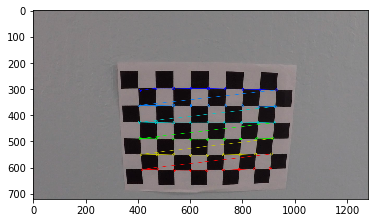

In [249]:
c.calibrate(image.read_dir('./camera_cal'), 9, 6, display=True)

In [193]:
ls = [f for f in os.listdir('./camera_cal') if f != "broken"]

In [189]:
images = image.read_dir('./camera_cal')

print('\n'.join([
    str(i) + ' ' + str(f) for i, f in zip(
        [str(i) + ' ' + str(img.shape) for i, img in zip(range(len(images)), images)], 
        ls
    )]
))

0 (720, 1280, 3) calibration18.jpg
1 (720, 1280, 3) calibration12.jpg
2 (720, 1280, 3) calibration10.jpg
3 (720, 1280, 3) calibration20.jpg
4 (721, 1281, 3) calibration15.jpg
5 (720, 1280, 3) calibration13.jpg
6 (720, 1280, 3) calibration6.jpg
7 (721, 1281, 3) calibration7.jpg
8 (720, 1280, 3) calibration14.jpg
9 (720, 1280, 3) calibration9.jpg
10 (720, 1280, 3) calibration2.jpg
11 (720, 1280, 3) calibration3.jpg
12 (720, 1280, 3) calibration19.jpg
13 (720, 1280, 3) calibration16.jpg
14 (720, 1280, 3) calibration11.jpg
15 (720, 1280, 3) calibration8.jpg
16 (720, 1280, 3) calibration17.jpg


In [255]:
x = np.array([[1,2],[3,4]])
x.reshape((x.shape[0], x.shape[1], 1))

array([[[1],
        [2]],

       [[3],
        [4]]])

In [257]:
np.tile(x, (3, 1, 1))

array([[[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]]])

In [ ]:
np.